# **For The Documentation Notebooks, I copied from**

- https://colab.research.google.com/drive/1q0RmeVRzLwRXW-h9dPFSOchwJkThUy6d

- https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo-nas-on-custom-dataset.ipynb

# **Imports**

In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [1]:
import matplotlib.pyplot as plt

# **Sneak peek: Inference with YOLONAS**

Before jumping into the section on fine-tuning, I wanted to show you the power of YOLONAS out of the box.

Start by instantiating a pretrained model. YOLONAS comes in three flavors: `yolo_nas_s`, `yolo_nas_m`, and `yolo_nas_l`.

You'll use `yolo_nas_l` throughout this notebook. Because you should always go big, or go home.

It's a good life philosophy.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# restart runTime before this cell
from super_gradients.training import models
yolo_nas_l = models.get("yolo_nas_s", pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2023-06-16 12:52:08] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-16 12:52:13] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-16 12:52:13] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-16 12:52:13] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-16 12:52:13] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-06-16 12:52:14] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with thes

  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


You can run the following cell if you're interested in the architecture:

In [ ]:
# !pip install torchinfo
# from torchinfo import summary

# summary(model=yolo_nas_l,
#         input_size=(16, 3, 640, 640),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

#  **Fine-tuning YOLONAS on custom dataset**

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [5]:
from super_gradients.training import Trainer
CHECKPOINT_DIR = '/content/drive/MyDrive/Fashion Search Engine Project/Items Detection/checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

# 💾 **Datasets and DataLoaders**

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.


In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="Nvzb1uVnPL5Su5x3i5gU")
# project = rf.workspace("fashion-project-nzsr2").project("fashion-project-3gdqk")
# dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Fashion-Project-3 in yolov5pytorch:: 100%|██████████| 1052/1052 [00:00<00:00, 3869.71it/s]


Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [6]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [7]:
Project_path='/content/drive/MyDrive/Fashion Search Engine Project'
dataset_params = {
    'data_dir': f'{Project_path}/Data/Dataset_Extracted/FashionDatasetSampledForYolo',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': [
    'Suitcase', 'Miniskirt', 'Tie', 'Luggage & bags', 'Shoe', 'Belt', 'Outerwear', 'Dress',
    'Earrings', 'Bracelet', 'Necklace', 'Brassiere', 'Footwear',
    'Satchel', 'Bowtie', 'Top', 'Pants', 'Sunglasses', 'Swimwear', 'Clothing',
    'Glove', 'Skirt', 'High heels', 'Underpants',
    'Fedora', 'Sun hat', 'Sock',
    'Wallet', 'Scarf', 'Watch', 'Umbrella', 'Glasses',
    'Boot', 'Basket', 'Backpack', 'Bag',
    'Hat', 'Coat', 'Sandal', 'Shorts', 'Jeans', 'Shirt', 'Handbag', 'Jacket'
]
}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format. This particular dataset has many such annotations, thus the warnings will be muted.

In [8]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

### 🧐 Now inspect the dataset defined earlier.

SuperGradients added `transforms` for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from `torchvision.transforms`, `albumentations` or a custom tranformaton.

In [9]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

You can plot a batch of training data with their augmentations applied to see what they look like:

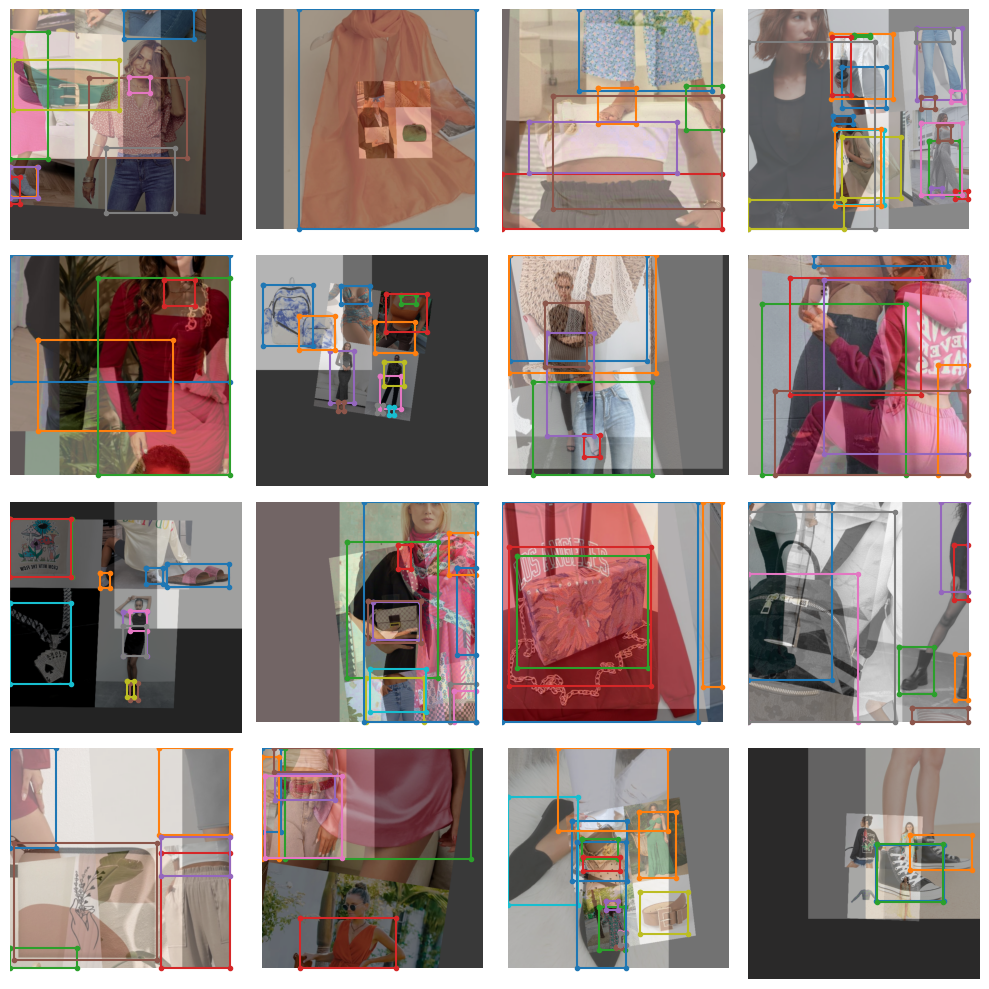

In [10]:
train_data.dataset.plot()

# 👩🏽‍🦳 **Instantiating the model**

You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [11]:
from super_gradients.training import models
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-06-16 13:44:40] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


# 🎛️ **Training parameters**

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [12]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 **Training the model**

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-06-16 13:45:09] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-16 13:45:13] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to /content/drive/MyDrive/Fashion Search Engine Project/Items Detection/checkpoints/my_first_yolonas_run/console_Jun16_13_45_14.txt


[2023-06-16 13:45:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2100       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         131        (len(train_loader))
    - Gradient updates per epoch:   131        (len(train_loader) / batch_accumulate)

[2023-06-16 13:50:04] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Fashion Search Engine Project/Items Detection/checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-06-16 13:50:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.00033301374060101807

# 🏆 **Get the best trained model**

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/drive/MyDrive/Fashion Search Engine Project/Items Detection/checkpoints/my_first_yolonas_run/average_model.pth")

[2023-06-14 13:16:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Fashion Search Engine Project/Items Detection/checkpoints/my_first_yolonas_run/average_model.pth EMA checkpoint.


# 🧐 **Evaluating the best trained model on the test set**

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

NameError: ignored

# 🔮 **Predicting with the best model**

The next line will perform detection on the following image. Note, we didn't have a class for the half dollar coin. So it will likely get classified as something else.







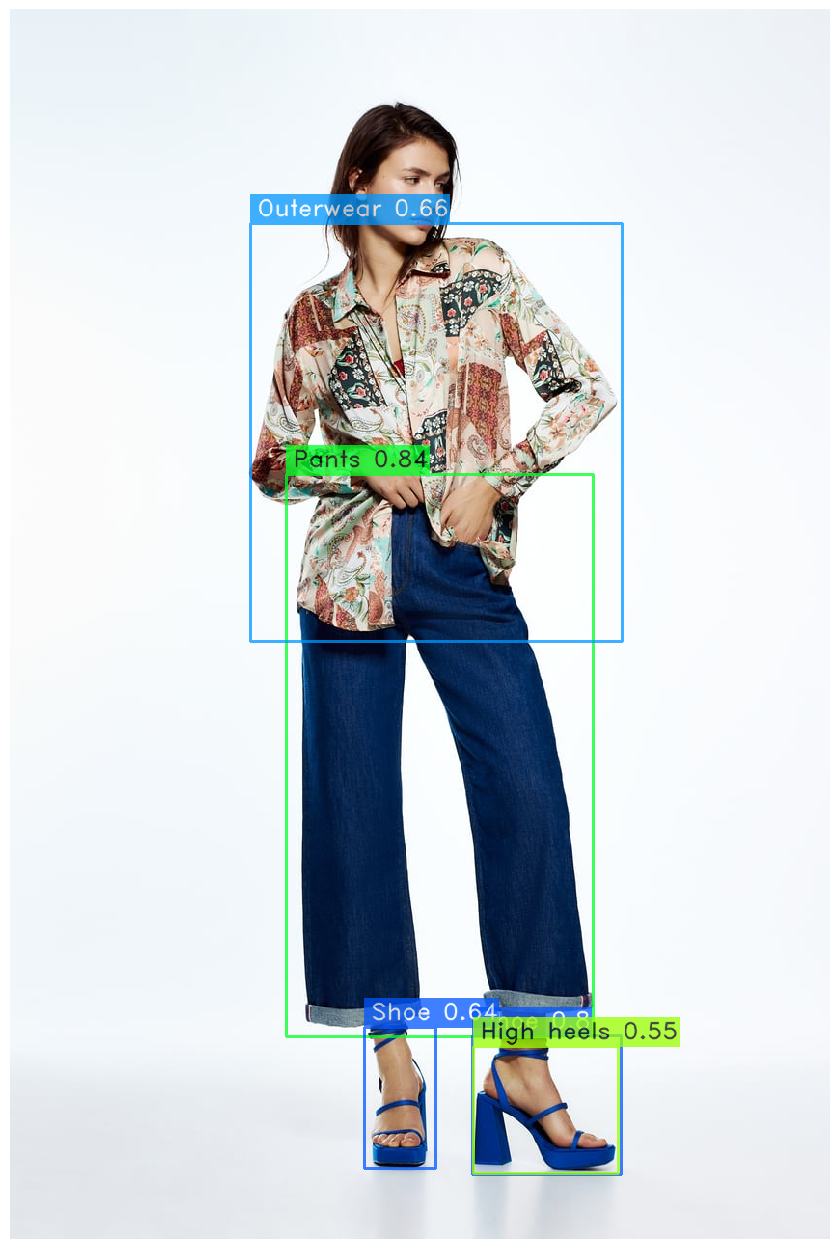

In [ ]:
img_url = '/content/drive/MyDrive/Fashion Search Engine Project/Data/Dataset_Extracted/FashionDatasetSampledForYolo/test/images/0026e7eab2457e29c30932da8e1d601451f1eb0d_0.jpg'
best_model.predict(img_url).show()

In [ ]:
# def extract_clothes(img_path: str):
#     '''
#     Extract Topwear, Bottomwear, and Footwear from a given Image
#     Note: In case there are multiple items of the same class, the item with the highest confidence score is returned.

#     Args:
#         img_path: Path to the image file that you want to extract clothes from.

#     Returns:
#         outputs: Dict[numpy.ndarray], Dictionary containing detected Object Class as Keys and the image slice as Values. Also contains the original image.
#     '''
#     image = plt.imread(img_path)
#     results = list(best_model.predict(img_path, conf=0.5))[0].prediction
#     topwear_score, bottomwear_score, footwear_score, Accessories_score= 0, 0, 0, 0
#     outputs = {"original_image": image}
#     for i in range (len(results.bboxes_xyxy)):

#         XMIN, YMIN, XMAX, YMAX = results.bboxes_xyxy[i]
#         confidence = results.confidence[i]
#         label = results.labels[i]

#         if (label == 0) and (confidence > Accessories_score):
#             Accessories_score = confidence
#             outputs["Accessories"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

#         elif (label == 1) and (confidence > bottomwear_score):
#             bottomwear_score = confidence
#             outputs["bottomwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

#         elif (label == 2) and (confidence > footwear_score):
#             footwear_score = confidence
#             outputs["footwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

#         elif (label == 3) and (confidence > topwear_score):
#             topwear_score = confidence
#             outputs["topwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

#     return outputs


In [ ]:
def extract_clothes(img_path: str):
    '''
    Extract Topwear, Bottomwear, and Footwear from a given Image
    Note: In case there are multiple items of the same class, the item with the highest confidence score is returned.

    Args:
        img_path: Path to the image file that you want to extract clothes from.

    Returns:
        outputs: Dict[numpy.ndarray], Dictionary containing detected Object Class as Keys and the image slice as Values. Also contains the original image.
    '''
    image = plt.imread(img_path)
    results = list(best_model.predict(img_path, conf=0.5))[0].prediction
    outputs = {"original_image": image}

    Suitcase_score, Miniskirt_score, Tie_score, Luggage_bags_score, Shoe_score, Belt_score, Outerwear_score, Dress_score, Earrings_score, Bracelet_score, Necklace_score, Brassiere_score, Footwear_score, Satchel_score, Bowtie_score, Top_score, Pants_score, Sunglasses_score, Swimwear_score, Clothing_score, Glove_score, Skirt_score, High_heels_score, Underpants_score, Fedora_score, Sun_hat_score, Sock_score, Wallet_score, Scarf_score, Watch_score, Umbrella_score, Glasses_score, Boot_score, Basket_score, Backpack_score, Bag_score, Hat_score, Coat_score, Sandal_score, Shorts_score, Jeans_score, Shirt_score, Handbag_score, Jacket_score = [0] * 44

    for i in range(len(results.bboxes_xyxy)):
        XMIN, YMIN, XMAX, YMAX = results.bboxes_xyxy[i]
        confidence = results.confidence[i]
        label = results.labels[i]

        if (label == 0) and (confidence > Suitcase_score):
            Suitcase_score = confidence
            outputs["Suitcase"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 1) and (confidence > Miniskirt_score):
            Miniskirt_score = confidence
            outputs["Miniskirt"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 2) and (confidence > Tie_score):
            Tie_score = confidence
            outputs["Tie"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 3) and (confidence > Luggage_bags_score):
            Luggage_bags_score = confidence
            outputs["Luggage & bags"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 4) and (confidence > Shoe_score):
            Shoe_score = confidence
            outputs["Shoe"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 5) and (confidence > Belt_score):
            Belt_score = confidence
            outputs["Belt"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 6) and (confidence > Outerwear_score):
            Outerwear_score = confidence
            outputs["Outerwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 7) and (confidence > Dress_score):
            Dress_score = confidence
            outputs["Dress"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]
        elif (label == 8) and (confidence > Earrings_score):
            Earrings_score = confidence
            outputs["Earrings"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 9) and (confidence > Bracelet_score):
            Bracelet_score = confidence
            outputs["Bracelet"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 10) and (confidence > Necklace_score):
            Necklace_score = confidence
            outputs["Necklace"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 11) and (confidence > Brassiere_score):
            Brassiere_score = confidence
            outputs["Brassiere"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 12) and (confidence > Footwear_score):
            Footwear_score = confidence
            outputs["Footwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]
        elif (label == 13) and (confidence > Satchel_score):
            Satchel_score = confidence
            outputs["Satchel"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 14) and (confidence > Bowtie_score):
            Bowtie_score = confidence
            outputs["Bowtie"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 15) and (confidence > Top_score):
            Top_score = confidence
            outputs["Top"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 16) and (confidence > Pants_score):
            Pants_score = confidence
            outputs["Pants"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 17) and (confidence > Sunglasses_score):
            Sunglasses_score = confidence
            outputs["Sunglasses"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 18) and (confidence > Swimwear_score):
            Swimwear_score = confidence
            outputs["Swimwear"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 19) and (confidence > Clothing_score):
            Clothing_score = confidence
            outputs["Clothing"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 20) and (confidence > Glove_score):
            Glove_score = confidence
            outputs["Glove"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 21) and (confidence > Skirt_score):
            Skirt_score = confidence
            outputs["Skirt"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 22) and (confidence > High_heels_score):
            High_heels_score = confidence
            outputs["High heels"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 23) and (confidence > Underpants_score):
            Underpants_score = confidence
            outputs["Underpants"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 24) and (confidence > Fedora_score):
            Fedora_score = confidence
            outputs["Fedora"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 25) and (confidence > Sun_hat_score):
            Sun_hat_score = confidence
            outputs["Sun hat"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 26) and (confidence > Sock_score):
            Sock_score = confidence
            outputs["Sock"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 27) and (confidence > Wallet_score):
            Wallet_score = confidence
            outputs["Wallet"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 28) and (confidence > Scarf_score):
            Scarf_score = confidence
            outputs["Scarf"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 29) and (confidence > Watch_score):
            Watch_score = confidence
            outputs["Watch"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 30) and (confidence > Umbrella_score):
            Umbrella_score = confidence
            outputs["Umbrella"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 31) and (confidence > Glasses_score):
            Glasses_score = confidence
            outputs["Glasses"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 32) and (confidence > Boot_score):
            Boot_score = confidence
            outputs["Boot"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 33) and (confidence > Basket_score):
            Basket_score = confidence
            outputs["Basket"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 34) and (confidence > Backpack_score):
            Backpack_score = confidence
            outputs["Backpack"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 35) and (confidence > Bag_score):
            Bag_score = confidence
            outputs["Bag"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 36) and (confidence > Hat_score):
            Hat_score = confidence
            outputs["Hat"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 37) and (confidence > Coat_score):
            Coat_score = confidence
            outputs["Coat"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 38) and (confidence > Sandal_score):
            Sandal_score = confidence
            outputs["Sandal"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 39) and (confidence > Shorts_score):
            Shorts_score = confidence
            outputs["Shorts"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 40) and (confidence > Jeans_score):
            Jeans_score = confidence
            outputs["Jeans"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 41) and (confidence > Shirt_score):
            Shirt_score = confidence
            outputs["Shirt"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 42) and (confidence > Handbag_score):
            Handbag_score = confidence
            outputs["Handbag"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

        elif (label == 43) and (confidence > Jacket_score):
            Jacket_score = confidence
            outputs["Jacket"] = image[int(YMIN):int(YMAX), int(XMIN):int(XMAX)]

    return outputs


In [ ]:
def plot_clothes(**images):
    '''
    Plot a dictionary of Images in a row

    Args:
        Dict: Image Names and Images in numpy.ndarray format

    Returns:
        matplotlib.figure object
    '''
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.axis("off")
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

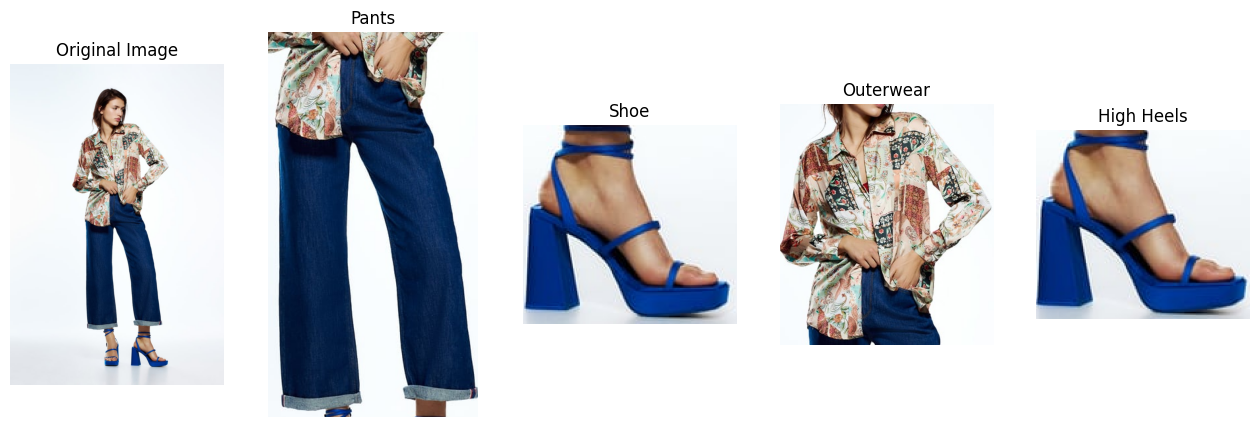

In [ ]:
outputs = extract_clothes(img_url)
plot_clothes(**outputs)